**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1.Read and understand the data

In [1]:
# import the libraries
import chardet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# detect the character
# read the first 1000 bytes to guess the encoding
with open("online-retail.csv","rb") as rawdata:
    result = chardet.detect(rawdata.read(100000))
    
print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [3]:
# read the csv file
retail_df = pd.read_csv("online-retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# get the number of records
retail_df.shape

(541909, 8)

In [5]:
# get the basic info
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [6]:
# find the missing values
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# get percentage of missing values
100*(retail_df.isnull().sum()/len(retail_df))

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [8]:
# drop the rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

# 3. Prepare the data for modeling

- R (Recency): number of days since last purchase
- F (Frequency): Total number of transactions in a year
- M (Monetory): Total amount of transactions in year

In [9]:
# get the head of df
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [10]:
# create a new column amount
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [11]:
# we want to find the total amount of transaction by a customer
# we will use groupby
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df.head()

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
Name: amount, dtype: float64

In [12]:
# make CustomerID a columns instead of index 
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [13]:
# create frequency column
# we will groupby CustomerID aggregrate on InoviceNO
frequency_df = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency_df.head()

CustomerID
12346.0      2
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: InvoiceNo, dtype: int64

In [14]:
# set the customerID as column instead of index
frequency_df = frequency_df.reset_index()
frequency_df.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
# change the name of the columns
frequency_df.columns = ['CustomerID','frequency']
frequency_df.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [16]:
# merge the monetory and frequency dataframe
grouped_df = pd.merge(grouped_df, frequency_df, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [17]:
# get head
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [18]:
# get info
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


In [19]:
# to work on date time, we need to convert InvoiceDate to datetime format
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [20]:
# get the maximum date of transaction to get a reference date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [21]:
# now get the date difference of every transaction with the max date
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [22]:
# create recency column
# we need to groupby CustomerID with min of the diff
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase.head()

CustomerID
12346.0   325 days 02:33:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
Name: diff, dtype: timedelta64[ns]

In [23]:
# create a customerID columns instead of index
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [24]:
# merge the recency to groupedby df
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID','amount','frequency','recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [25]:
# extact only number of days out of date time
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Preprocessing 
#### 1. Outlier Treatment
#### 2. Scaling

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3c92e99710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3c92e99cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3c92e994a8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3c92eb32b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3c92eb3588>],
 'means': []}

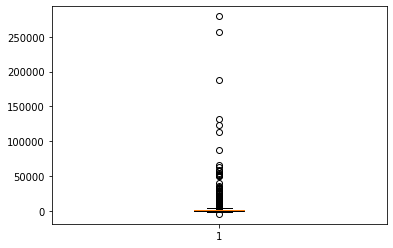

In [26]:
# box plot to analyze the outliers
plt.boxplot(grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3c92dfbda0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3c92d8c390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3c92dfbb38>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3c92d8c940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3c92d8cc18>],
 'means': []}

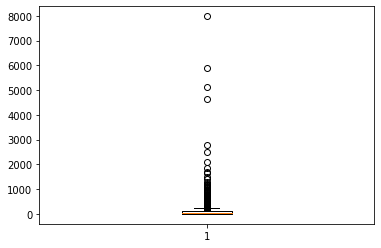

In [27]:
plt.boxplot(grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3c92d73a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3c92d81048>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3c92d737f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3c92d815f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3c92d818d0>],
 'means': []}

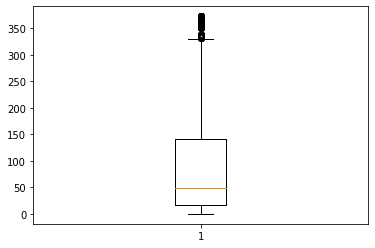

In [28]:
plt.boxplot(grouped_df['recency'])

In [29]:
# removing outliers(statistical)
# we will treat values above 95 and below 0.05 percentile as outliers

# for amount
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1

grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

grouped_df.head()

# for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1

grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]


# for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1

grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [30]:
# rescaling
# create a subset dataframe
rfm_df = grouped_df[['amount','frequency','recency']]
rfm_df.head()

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [31]:
# import the library
import sklearn
from sklearn.preprocessing import StandardScaler

In [32]:
# intantiate the scaler
scaler = StandardScaler()

# fit and transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [33]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [34]:
#First convert the numpy array that you have to a dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

In [35]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9544083473216247

In [36]:
# iterate again
hopkins(rfm_df_scaled)

0.9544000735970974

In [37]:
# iterate again
hopkins(rfm_df_scaled)

0.9551367474488693

# 4. Modeling

In [38]:
# import the library for KMeans cluster
from sklearn.cluster import KMeans

In [39]:
# intantiate KMeans for some arbitary K
kmeans = KMeans(n_clusters=4, max_iter=50)

In [40]:
# fit the data
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [41]:
# get the labels
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

## Find optimal number of clusters
### 1. elbow curve method
### 2. Silhouette

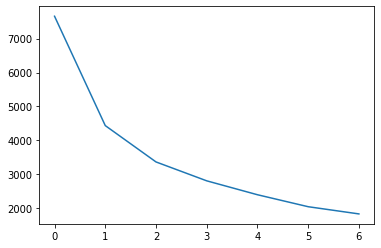

In [42]:
# elbow-curve/SSD

# initialize a empty list
ssd = []

# number fo clusters we want to try out
no_of_clusters = [2,3,4,5,6,7,8]

# iterate through each number of cluster and fit the model and find the inertia (SSD => Sum of Squared Distance)
for num_cluster in no_of_clusters:
    kmeans = KMeans(n_clusters=num_cluster, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    # store the inertia in a list to plot later
    ssd.append(kmeans.inertia_)
    
# plot the ssd
plt.plot(ssd)

In [43]:
# silhouette analysis
from sklearn.metrics import silhouette_score

In [44]:
# define number of clusters
no_of_clusters = [2,3,4,5,6,7,8]

# iterate through each no of clusters and compute the silhouette score
for num_clusters in no_of_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    # get the labels
    cluster_label = kmeans.labels_
    
    # get the silhouetter score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_label)
    print('for {0} number of cluster, silhouette score is {1}'.format(num_clusters, silhouette_avg))

for 2 number of cluster, silhouette score is 0.5415858652525395
for 3 number of cluster, silhouette score is 0.5084896296141937
for 4 number of cluster, silhouette score is 0.4777820100216849
for 5 number of cluster, silhouette score is 0.46413788559626845
for 6 number of cluster, silhouette score is 0.41758431193450735
for 7 number of cluster, silhouette score is 0.4150058806779277
for 8 number of cluster, silhouette score is 0.40224227965264964


In [45]:
# we decided to go ahead with 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [46]:
# get the labels (numpy array)
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [47]:
# assing the labels to CustomerID
# since the order of grouped_df is not changed , we can directly concat the dfs
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

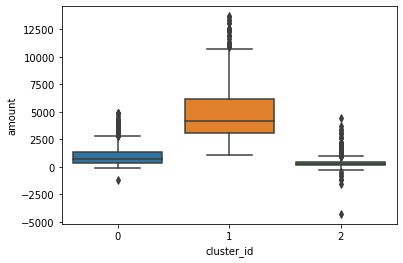

In [48]:
# cluster analysis on amount
sns.boxplot(x='cluster_id',y='amount',data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

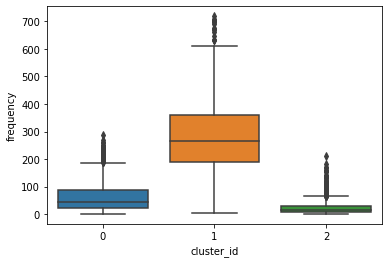

In [49]:
# cluster analysis on frequency
sns.boxplot(x='cluster_id',y='frequency',data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

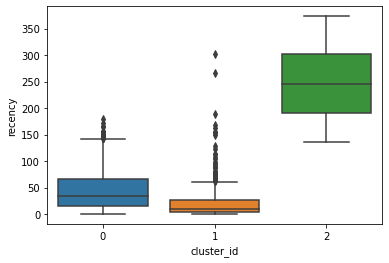

In [50]:
# cluster analysis on recency
sns.boxplot(x='cluster_id',y='recency',data=grouped_df)